## Нормализованный датасет

In [1]:
import os
import pandas as pd

os.chdir('../../../')

In [2]:
df_normalized = pd.read_csv('data/lmsys-chat-1m/processed/features_normalized.csv',)

### Матрица корреляции

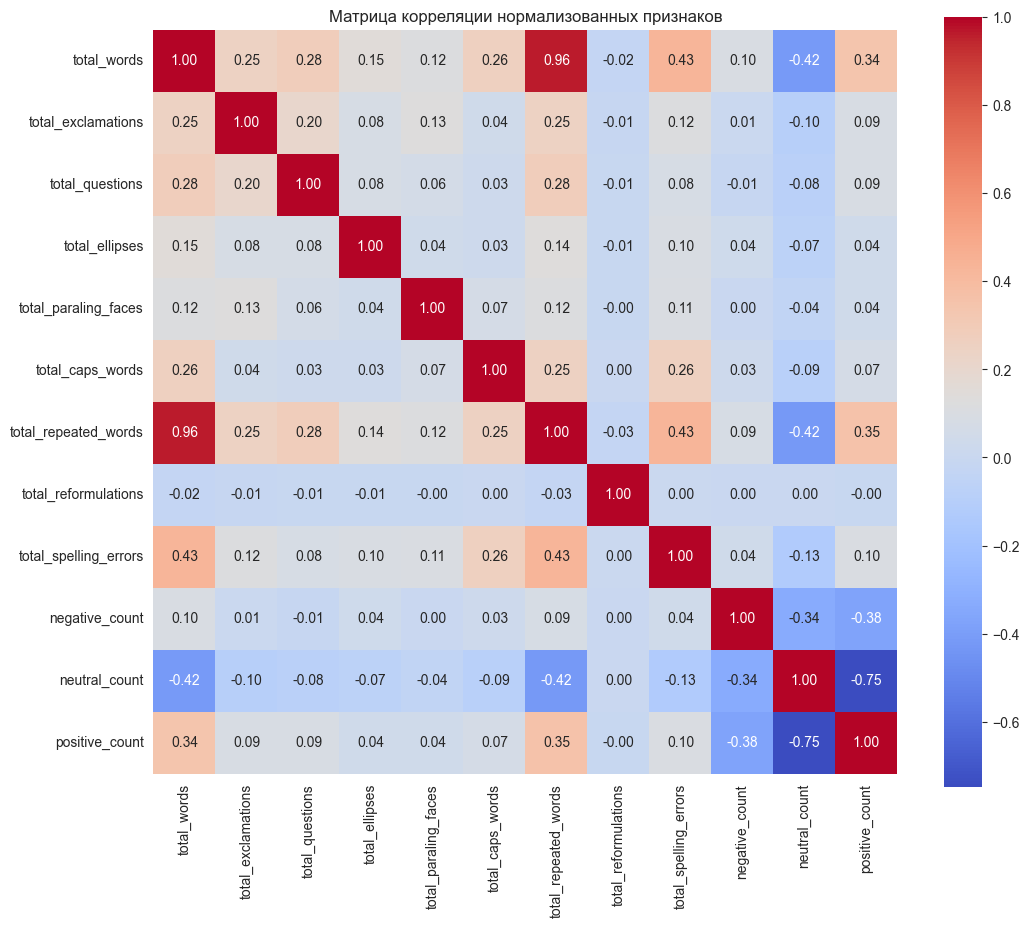

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = [
    col for col in df_normalized.columns
    if col != 'user_id' and pd.api.types.is_numeric_dtype(df_normalized[col])
]

# Строим матрицу корреляции
corr_matrix = df_normalized[numeric_cols].corr()

# Визуализация
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Матрица корреляции нормализованных признаков")
plt.show()


### Уберем признаки с сильной корреляцией

In [4]:
df_normalized.drop(['total_repeated_words'], inplace=True, axis=1)
# df_normalized.drop(['neutral_count'], inplace=True, axis=1)


### Подготовка данных

In [5]:
from sklearn.preprocessing import StandardScaler

X = df_normalized.drop(columns=['user_id'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Подбор значений

Подбор min_samples: 100%|██████████| 4/4 [04:22<00:00, 65.58s/it]


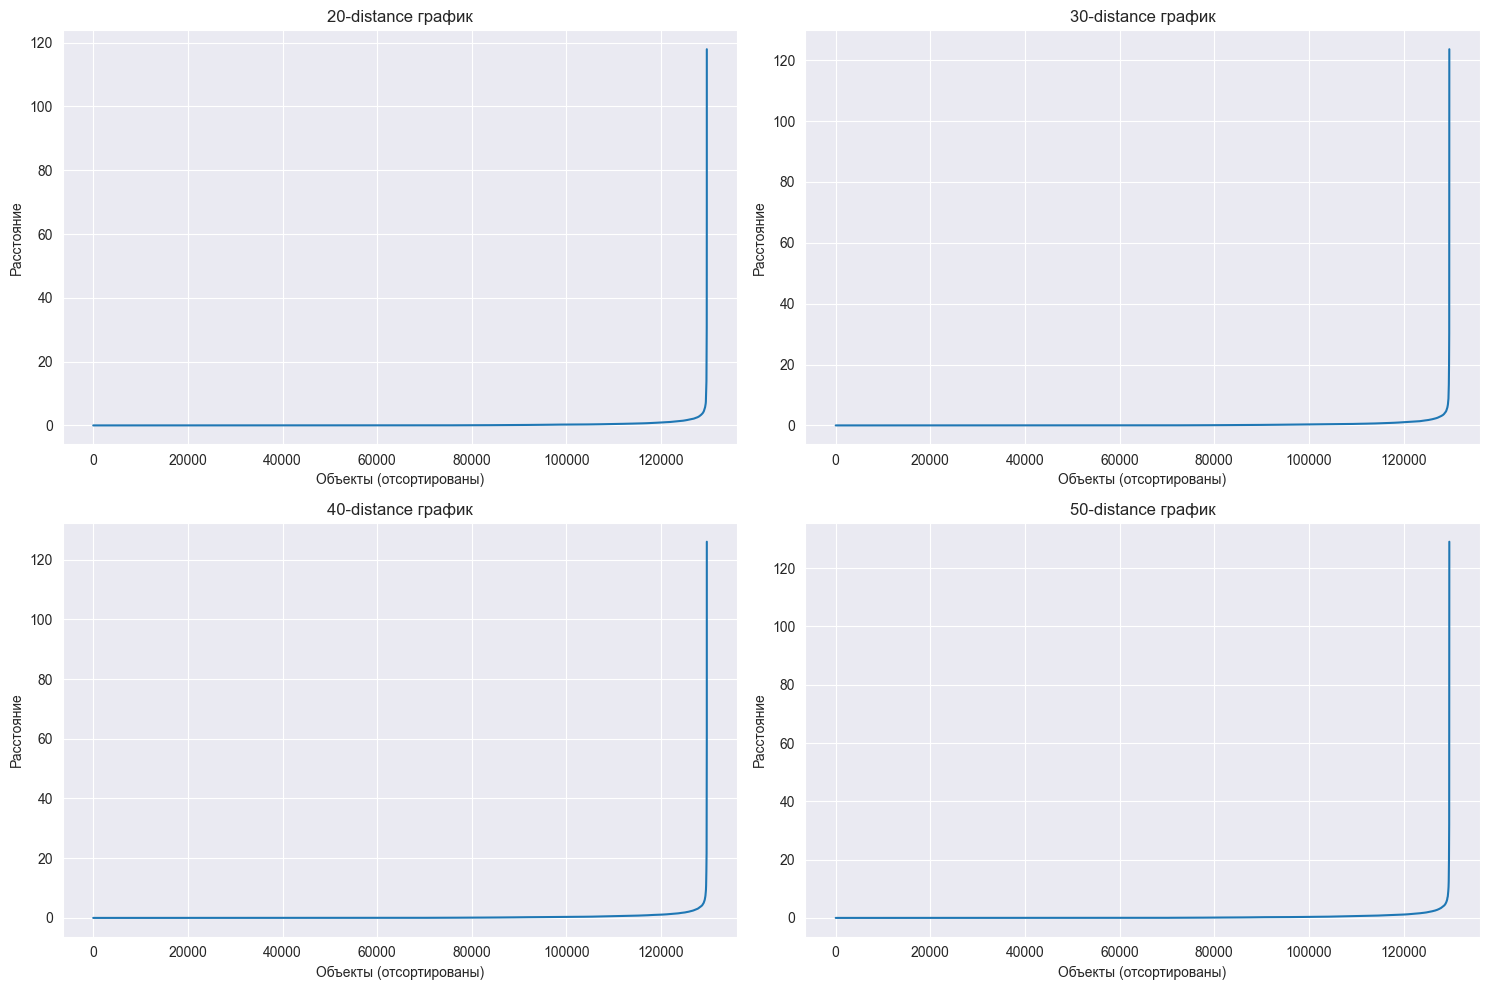

In [6]:
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

min_samples_list = [20, 30, 40, 50]

plt.figure(figsize=(15, 10))

for i, min_samples in enumerate(tqdm(min_samples_list, desc="Подбор min_samples"), 1):
    nn = NearestNeighbors(n_neighbors=min_samples)
    nn.fit(X_scaled)
    distances, _ = nn.kneighbors(X_scaled)

    k_distances = np.sort(distances[:, -1])

    plt.subplot(2, 2, i)
    plt.plot(k_distances)
    plt.title(f"{min_samples}-distance график")
    plt.xlabel("Объекты (отсортированы)")
    plt.ylabel("Расстояние")
    plt.grid(True)

plt.tight_layout()
plt.show()



### Обучение DBSCAN

In [7]:
from sklearn.cluster import DBSCAN
import numpy as np

# Подвыборка
sample_size = 30000
idx_sample = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sampled = X_scaled[idx_sample]

# Обучаем DBSCAN на подвыборке
dbscan = DBSCAN(eps=13.0, min_samples=30)
dbscan_labels = dbscan.fit_predict(X_sampled)

# Собираем кластерный датафрейм для этой подвыборки
df_dbscan_clusters_sampled = df_normalized.iloc[idx_sample][['user_id']].copy()
df_dbscan_clusters_sampled['dbscan_cluster'] = dbscan_labels


### Анализ кластеров

In [8]:
df_dbscan_clusters_sampled['dbscan_cluster'].value_counts()

dbscan_cluster
 0    29974
-1       26
Name: count, dtype: int64

### Визуализация

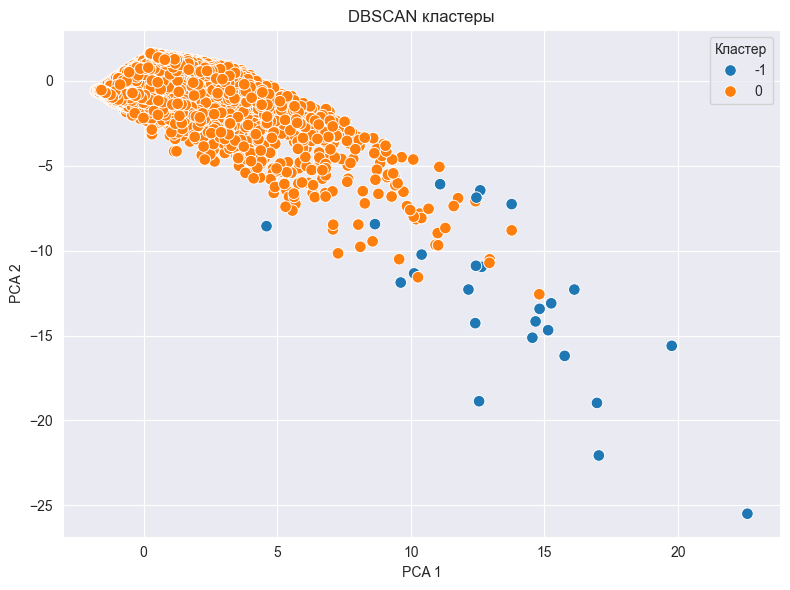

In [9]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# PCA до 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sampled)

# Собираем визуализационный df
df_dbscan_vis = df_dbscan_clusters_sampled.copy()
df_dbscan_vis['pca1'] = X_pca[:, 0]
df_dbscan_vis['pca2'] = X_pca[:, 1]

# Отображаем
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_dbscan_vis,
    x='pca1',
    y='pca2',
    hue='dbscan_cluster',
    palette='tab10',
    s=70
)
plt.title("DBSCAN кластеры")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Кластер")
plt.grid(True)
plt.tight_layout()
plt.show()


### Силуэт оценка DBSCAN

In [10]:
from sklearn.metrics import silhouette_score

# Отфильтруем шум
mask_core = dbscan_labels != -1
X_core = X_sampled[mask_core]
labels_core = dbscan_labels[mask_core]

n_clusters = len(set(labels_core))
if n_clusters >= 2:
    sil_score = silhouette_score(X_core, labels_core)
    print(f"Silhouette Score (DBSCAN): {sil_score:.3f}")
else:
    print("Недостаточно кластеров (без учёта шума) для оценки силуэта.")


Недостаточно кластеров (без учёта шума) для оценки силуэта.
